## Big Data Analytics - Lab Quest 3
### Instructure: Michał Rudko
### Student: Nhat Tung Le, Id 426246, Group 1

# Abstract

Recommender System uses AI technology to analyze and understand personal data blocks, thereby, making predictions, suggesting recommendations that match the user's preferences at the time. any on online applications and platforms to save time searching, easy access to content, and at the same time, help businesses improve customer experience.

In this project, I use Apache Spark, SQL, and MLib for data analysis, and build a recommendation system based on the MovieLens dataset.

# 1. Introduction

## 1.1. Apache Spark 

Apache Spark is an open source cluster computing framework, originally developed in 2009 by AMPLab. Later on, Spark was given to Apache Software Foundation in 2013 and developed to date.

Spark's processing speed is achieved because the computation is done at the same time on many different machines. At the same time, the calculation is done in internal memory (in-memories) or done entirely in RAM.

Spark allows real-time data processing, both receiving data from different sources and immediately performing processing on the received data (Spark Streaming).

Spark does not have its own file system, it uses other file systems such as: HDFS, Cassandra, S3,.... Spark supports many different file formats (text, csv, json…) and it is completely independent of any file system.

Apache Spark consists of 5 main components: Spark Core, Spark Streaming, Spark SQL, MLlib and GraphX.

## 1.2. PyPark

PySpark is the Python API for Apache Spark, an open source, distributed computing framework and set of libraries for real-time, large-scale data processing. If you’re already familiar with Python and libraries such as Pandas, then PySpark is a good language to learn to create more scalable analyses and pipelines.

To install PysPark, we can use the following command:

In [54]:
# !pip install pyspark

## 1.3. MLlib

MLlib is Spark’s machine learning (ML) library. Its goal is to make practical machine learning scalable and easy. At a high level, it provides tools such as:
* ML Algorithms: common learning algorithms such as classification, regression, clustering, and collaborative filtering
* Featurization: feature extraction, transformation, dimensionality reduction, and selection
* Pipelines: tools for constructing, evaluating, and tuning ML Pipelines
* Persistence: saving and load algorithms, models, and Pipelines
* Utilities: linear algebra, statistics, data handling, etc.

## 1.4. MovieLens 20M Dataset

MovieLens 20M movie ratings. Stable benchmark dataset. 20 million ratings and 465,000 tag applications applied to 27,000 movies by 138,000 users. Includes tag genome data with 12 million relevance scores across 1,100 tags. Released 4/2015; updated 10/2016 to update links.csv and add tag genome data.

Link: <a href="https://grouplens.org/datasets/movielens/20m/">https://grouplens.org/datasets/movielens/20m/</a>

# 2. Exploratory data analysis

## 2.1. Libs and create spark app

In [143]:
# Required libraries:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession 
from pyspark.sql import functions as F 
from pyspark.sql.functions import col, split, explode
from pyspark.sql.functions import sum as _sum
from pyspark.sql.functions import countDistinct as _countDistinct
from pyspark.sql.functions import avg as _avg
from pyspark.sql.functions import rank
from pyspark.sql.functions import substring,length
from pyspark.sql.types import DateType, StringType, FloatType, IntegerType 
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.window import Window


In [58]:
# Change chdir, check files
path = "C:/Users/Windows/Documents/GitHub/movielens/ml-20m/ml-20m"
os.chdir(path)
os.listdir()

['genome-scores.csv',
 'genome-tags.csv',
 'links.csv',
 'movies.csv',
 'ratings.csv',
 'README.txt',
 'tags.csv']

In [59]:
# Create spark
spark = SparkSession.builder.master('local[*]').appName("MovieLens").getOrCreate()

## 2.2. Check schema and create DataFrame

In [62]:
## movies
movies_df = spark.read.csv("movies.csv", sep=",", header = True, inferSchema=True, nullValue="NA")
movies_df.show() 
movies_df.printSchema()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [63]:
## tags
tags_df = spark.read.csv("tags.csv", sep=",", header = True, inferSchema=True, nullValue="NA")
tags_df.show() 
tags_df.printSchema()

+------+-------+-----------------+----------+
|userId|movieId|              tag| timestamp|
+------+-------+-----------------+----------+
|    18|   4141|      Mark Waters|1240597180|
|    65|    208|        dark hero|1368150078|
|    65|    353|        dark hero|1368150079|
|    65|    521|    noir thriller|1368149983|
|    65|    592|        dark hero|1368150078|
|    65|    668|        bollywood|1368149876|
|    65|    898| screwball comedy|1368150160|
|    65|   1248|    noir thriller|1368149983|
|    65|   1391|             mars|1368150055|
|    65|   1617|         neo-noir|1368150217|
|    65|   1694|            jesus|1368149925|
|    65|   1783|    noir thriller|1368149983|
|    65|   2022|            jesus|1368149925|
|    65|   2193|           dragon|1368151314|
|    65|   2353|conspiracy theory|1368151266|
|    65|   2662|             mars|1368150055|
|    65|   2726|    noir thriller|1368149983|
|    65|   2840|            jesus|1368149925|
|    65|   3052|            jesus|

In [64]:
## ratings
ratings_df = spark.read.csv("ratings.csv", sep=",", header = True, inferSchema=True, nullValue="NA")
ratings_df.show() 
ratings_df.printSchema()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|      2|   3.5|1112486027|
|     1|     29|   3.5|1112484676|
|     1|     32|   3.5|1112484819|
|     1|     47|   3.5|1112484727|
|     1|     50|   3.5|1112484580|
|     1|    112|   3.5|1094785740|
|     1|    151|   4.0|1094785734|
|     1|    223|   4.0|1112485573|
|     1|    253|   4.0|1112484940|
|     1|    260|   4.0|1112484826|
|     1|    293|   4.0|1112484703|
|     1|    296|   4.0|1112484767|
|     1|    318|   4.0|1112484798|
|     1|    337|   3.5|1094785709|
|     1|    367|   3.5|1112485980|
|     1|    541|   4.0|1112484603|
|     1|    589|   3.5|1112485557|
|     1|    593|   3.5|1112484661|
|     1|    653|   3.0|1094785691|
|     1|    919|   3.5|1094785621|
+------+-------+------+----------+
only showing top 20 rows

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timesta

In [65]:
## links
links_df = spark.read.csv("links.csv", sep=",", header = True, inferSchema=True, nullValue="NA")
links_df.show() 
links_df.printSchema()

+-------+------+------+
|movieId|imdbId|tmdbId|
+-------+------+------+
|      1|114709|   862|
|      2|113497|  8844|
|      3|113228| 15602|
|      4|114885| 31357|
|      5|113041| 11862|
|      6|113277|   949|
|      7|114319| 11860|
|      8|112302| 45325|
|      9|114576|  9091|
|     10|113189|   710|
|     11|112346|  9087|
|     12|112896| 12110|
|     13|112453| 21032|
|     14|113987| 10858|
|     15|112760|  1408|
|     16|112641|   524|
|     17|114388|  4584|
|     18|113101|     5|
|     19|112281|  9273|
|     20|113845| 11517|
+-------+------+------+
only showing top 20 rows

root
 |-- movieId: integer (nullable = true)
 |-- imdbId: integer (nullable = true)
 |-- tmdbId: integer (nullable = true)



In [66]:
## genome-tags
genome_tags_df = spark.read.csv("genome-tags.csv", sep=",", header = True, inferSchema=True, nullValue="NA")
genome_tags_df.show() 
genome_tags_df.printSchema()

+-----+---------------+
|tagId|            tag|
+-----+---------------+
|    1|            007|
|    2|   007 (series)|
|    3|   18th century|
|    4|          1920s|
|    5|          1930s|
|    6|          1950s|
|    7|          1960s|
|    8|          1970s|
|    9|          1980s|
|   10|   19th century|
|   11|             3d|
|   12|           70mm|
|   13|            80s|
|   14|           9/11|
|   15|        aardman|
|   16|aardman studios|
|   17|       abortion|
|   18|         absurd|
|   19|         action|
|   20|  action packed|
+-----+---------------+
only showing top 20 rows

root
 |-- tagId: integer (nullable = true)
 |-- tag: string (nullable = true)



In [68]:
## genome-scores
genome_scores_df = spark.read.csv("genome-scores.csv", sep=",", header = True, inferSchema=True, nullValue="NA")
genome_scores_df.show() 
genome_scores_df.printSchema()

+-------+-----+--------------------+
|movieId|tagId|           relevance|
+-------+-----+--------------------+
|      1|    1|0.025000000000000022|
|      1|    2|0.025000000000000022|
|      1|    3|0.057750000000000024|
|      1|    4|             0.09675|
|      1|    5|             0.14675|
|      1|    6| 0.21700000000000003|
|      1|    7|               0.067|
|      1|    8| 0.26275000000000004|
|      1|    9|               0.262|
|      1|   10| 0.03199999999999997|
|      1|   11|               0.577|
|      1|   12| 0.11625000000000002|
|      1|   13|               0.188|
|      1|   14|0.008000000000000007|
|      1|   15|0.036750000000000005|
|      1|   16| 0.28174999999999994|
|      1|   17|0.007000000000000006|
|      1|   18| 0.11049999999999999|
|      1|   19|              0.6705|
|      1|   20|              0.1845|
+-------+-----+--------------------+
only showing top 20 rows

root
 |-- movieId: integer (nullable = true)
 |-- tagId: integer (nullable = true)
 |-

In [71]:
# Summary all DataFrame
display(movies_df)
display(tags_df)
display(genome_tags_df)
display(genome_scores_df)
display(links_df)
display(ratings_df)

DataFrame[movieId: int, title: string, genres: string]

DataFrame[userId: int, movieId: int, tag: string, timestamp: int]

DataFrame[tagId: int, tag: string]

DataFrame[movieId: int, tagId: int, relevance: double]

DataFrame[movieId: int, imdbId: int, tmdbId: int]

DataFrame[userId: int, movieId: int, rating: double, timestamp: int]

## 2.3. Informations

In [75]:
# Number of unique movies
movies_df.createOrReplaceTempView("movies")
unique_movies = spark.sql("SELECT COUNT(DISTINCT movieId) FROM movies").collect()[0][0]
print("Number of unique movies:", unique_movies)

Number of unique movies: 27278


In [76]:
# Number of users participating in rating points for movies
ratings_df.createOrReplaceTempView("ratings")
unique_users = spark.sql("SELECT COUNT(DISTINCT userId) FROM ratings").collect()[0][0]
print("Number of users participating in rating points for movies:", unique_users)

Number of users participating in rating points for movies: 138493


In [77]:
# Split genres
movies_df_2 = movies_df.withColumn("genres", explode(split("genres", "[|]")))
movies_df_2.show()
movies_df_2.printSchema()

+-------+--------------------+---------+
|movieId|               title|   genres|
+-------+--------------------+---------+
|      1|    Toy Story (1995)|Adventure|
|      1|    Toy Story (1995)|Animation|
|      1|    Toy Story (1995)| Children|
|      1|    Toy Story (1995)|   Comedy|
|      1|    Toy Story (1995)|  Fantasy|
|      2|      Jumanji (1995)|Adventure|
|      2|      Jumanji (1995)| Children|
|      2|      Jumanji (1995)|  Fantasy|
|      3|Grumpier Old Men ...|   Comedy|
|      3|Grumpier Old Men ...|  Romance|
|      4|Waiting to Exhale...|   Comedy|
|      4|Waiting to Exhale...|    Drama|
|      4|Waiting to Exhale...|  Romance|
|      5|Father of the Bri...|   Comedy|
|      6|         Heat (1995)|   Action|
|      6|         Heat (1995)|    Crime|
|      6|         Heat (1995)| Thriller|
|      7|      Sabrina (1995)|   Comedy|
|      7|      Sabrina (1995)|  Romance|
|      8| Tom and Huck (1995)|Adventure|
+-------+--------------------+---------+
only showing top

In [93]:
# Statistics of movies by genre:
genres_count_df = movies_df_2.groupBy("genres").count()
genres_count_df.show()

+------------------+-----+
|            genres|count|
+------------------+-----+
|             Crime| 2939|
|           Romance| 4127|
|          Thriller| 4178|
|         Adventure| 2329|
|             Drama|13344|
|               War| 1194|
|       Documentary| 2471|
|           Fantasy| 1412|
|           Mystery| 1514|
|           Musical| 1036|
|         Animation| 1027|
|         Film-Noir|  330|
|(no genres listed)|  246|
|              IMAX|  196|
|            Horror| 2611|
|           Western|  676|
|            Comedy| 8374|
|          Children| 1139|
|            Action| 3520|
|            Sci-Fi| 1743|
+------------------+-----+



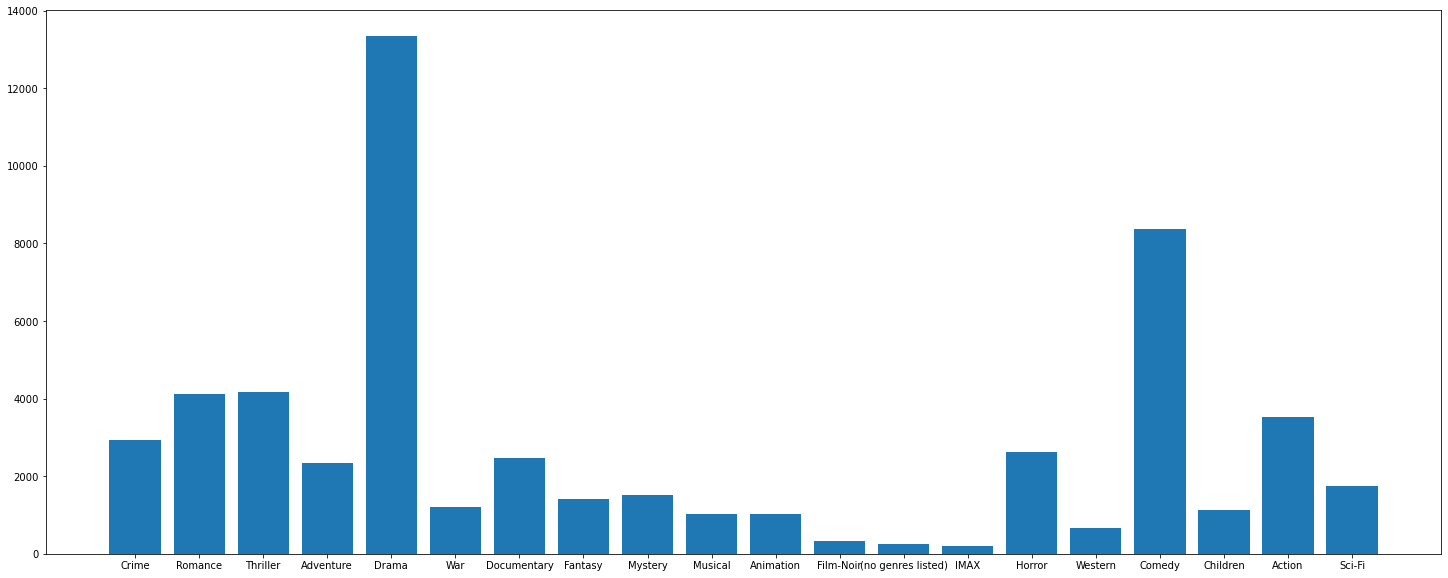

In [101]:
genres_count_df_2 = genres_count_df.select("genres", "count").toPandas()
plt.figure(figsize=(25, 10))
plt.bar(genres_count_df_2['genres'], genres_count_df_2['count'])
plt.show()

In [104]:
# Join movies_df & ratings_df
joined_ratings_df = movies_df.join(ratings_df, movies_df.movieId == ratings_df.movieId, "inner").drop(ratings_df.movieId)
joined_ratings_df.show()

+-------+--------------------+--------------------+------+------+----------+
|movieId|               title|              genres|userId|rating| timestamp|
+-------+--------------------+--------------------+------+------+----------+
|      2|      Jumanji (1995)|Adventure|Childre...|     1|   3.5|1112486027|
|     29|City of Lost Chil...|Adventure|Drama|F...|     1|   3.5|1112484676|
|     32|Twelve Monkeys (a...|Mystery|Sci-Fi|Th...|     1|   3.5|1112484819|
|     47|Seven (a.k.a. Se7...|    Mystery|Thriller|     1|   3.5|1112484727|
|     50|Usual Suspects, T...|Crime|Mystery|Thr...|     1|   3.5|1112484580|
|    112|Rumble in the Bro...|Action|Adventure|...|     1|   3.5|1094785740|
|    151|      Rob Roy (1995)|Action|Drama|Roma...|     1|   4.0|1094785734|
|    223|       Clerks (1994)|              Comedy|     1|   4.0|1112485573|
|    253|Interview with th...|        Drama|Horror|     1|   4.0|1112484940|
|    260|Star Wars: Episod...|Action|Adventure|...|     1|   4.0|1112484826|

In [131]:
# Top 150 highest rated films 
# groupBy by and orderBy desc
joined_ratings_df.drop("timestamp")
joined_avg_ratings_df = joined_ratings_df.groupBy("userId", "title").agg(_avg("rating").alias("avg_rating"))
desc_df = joined_avg_ratings_df.orderBy(joined_avg_ratings_df.avg_rating.desc())
# desc_df.show()

In [132]:
# Print topp 150
top_150 = desc_df.limit(150)
top_150.show(150)

+--------------------+-----------------+
|               title|       avg_rating|
+--------------------+-----------------+
|Schmatta: Rags to...|              5.0|
|A Night for Dying...|              5.0|
|Boys (Drenge) (1977)|              5.0|
|Little Criminals ...|              5.0|
|  Small Roads (2011)|              5.0|
|    Abendland (2011)|              5.0|
|The Garden of Sin...|              5.0|
|Snow Queen, The (...|              5.0|
|Pursuit of Unhapp...|              5.0|
|Foster Brothers, ...|              5.0|
|This Thing With S...|              5.0|
|No Distance Left ...|              5.0|
|Pretty Things (2001)|              5.0|
|     Mutantes (2009)|              5.0|
|       Poison (1951)|              5.0|
|Afstiros katallil...|              5.0|
|A Blank on the Ma...|              5.0|
|         1971 (2014)|              5.0|
|Going Down in LA-...|              5.0|
|Loser Takes All! ...|              5.0|
|     Bandaged (2009)|              5.0|
|Linotype: The F

# 3. Building a recommendation system

# 4. Conclusions

# References

https://spark.apache.org/

https://www.mastercode.vn/blog/web-development/apache-spark-la-gi.85

http://itechseeker.com/

https://en.wikipedia.org/wiki/Apache_Spark

https://viblo.asia/p/tim-hieu-ve-apache-spark-ByEZkQQW5Q0

https://www.dominodatalab.com/data-science-dictionary/pyspark#:~:text=PySpark%20is%20the%20Python%20API,more%20scalable%20analyses%20and%20pipelines.

https://spark.apache.org/docs/latest/ml-guide.html

https://grouplens.org/datasets/movielens/20m/

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages. DOI=http://dx.doi.org/10.1145/2827872

In [13]:
# JOIN TABLE

In [14]:
# Step 1
# Join movies_df & ratings_df
joined_df = movies_df.join(ratings_df, movies_df.movieId == ratings_df.movieId, "inner").drop(ratings_df.movieId)
joined_df.show()

+-------+--------------------+---------+------+------+----------+
|movieId|               title|   genres|userId|rating| timestamp|
+-------+--------------------+---------+------+------+----------+
|      2|      Jumanji (1995)|  Fantasy|     1|   3.5|1112486027|
|      2|      Jumanji (1995)| Children|     1|   3.5|1112486027|
|      2|      Jumanji (1995)|Adventure|     1|   3.5|1112486027|
|     29|City of Lost Chil...|   Sci-Fi|     1|   3.5|1112484676|
|     29|City of Lost Chil...|  Mystery|     1|   3.5|1112484676|
|     29|City of Lost Chil...|  Fantasy|     1|   3.5|1112484676|
|     29|City of Lost Chil...|    Drama|     1|   3.5|1112484676|
|     29|City of Lost Chil...|Adventure|     1|   3.5|1112484676|
|     32|Twelve Monkeys (a...| Thriller|     1|   3.5|1112484819|
|     32|Twelve Monkeys (a...|   Sci-Fi|     1|   3.5|1112484819|
|     32|Twelve Monkeys (a...|  Mystery|     1|   3.5|1112484819|
|     47|Seven (a.k.a. Se7...| Thriller|     1|   3.5|1112484727|
|     47|S

In [15]:
# Step 2
# Join joined_df & links
joined_df_2 = joined_df.join(links_df, joined_df.movieId == links_df.movieId, "inner").drop(links_df.movieId)
joined_df_2.show()

+-------+--------------------+---------+------+------+----------+------+------+
|movieId|               title|   genres|userId|rating| timestamp|imdbId|tmdbId|
+-------+--------------------+---------+------+------+----------+------+------+
|      2|      Jumanji (1995)|  Fantasy|     1|   3.5|1112486027|113497|  8844|
|      2|      Jumanji (1995)| Children|     1|   3.5|1112486027|113497|  8844|
|      2|      Jumanji (1995)|Adventure|     1|   3.5|1112486027|113497|  8844|
|     29|City of Lost Chil...|   Sci-Fi|     1|   3.5|1112484676|112682|   902|
|     29|City of Lost Chil...|  Mystery|     1|   3.5|1112484676|112682|   902|
|     29|City of Lost Chil...|  Fantasy|     1|   3.5|1112484676|112682|   902|
|     29|City of Lost Chil...|    Drama|     1|   3.5|1112484676|112682|   902|
|     29|City of Lost Chil...|Adventure|     1|   3.5|1112484676|112682|   902|
|     32|Twelve Monkeys (a...| Thriller|     1|   3.5|1112484819|114746|    63|
|     32|Twelve Monkeys (a...|   Sci-Fi|

In [23]:
# Step 3
# Join joined_df & tags_df
joined_df_3 = joined_df_2.join(tags_df, (joined_df_2.movieId == tags_df.movieId) & (joined_df_2.userId == tags_df.userId))
joined_df_3.show()

+-------+----------------+---------+------+------+----------+------+------+------+-------+------------------+----------+
|movieId|           title|   genres|userId|rating| timestamp|imdbId|tmdbId|userId|movieId|               tag| timestamp|
+-------+----------------+---------+------+------+----------+------+------+------+-------+------------------+----------+
|      1|Toy Story (1995)|  Fantasy| 23171|   3.5|1130926397|114709|   862| 23171|      1|             pixar|1140521984|
|      1|Toy Story (1995)|   Comedy| 23171|   3.5|1130926397|114709|   862| 23171|      1|             pixar|1140521984|
|      1|Toy Story (1995)| Children| 23171|   3.5|1130926397|114709|   862| 23171|      1|             pixar|1140521984|
|      1|Toy Story (1995)|Animation| 23171|   3.5|1130926397|114709|   862| 23171|      1|             pixar|1140521984|
|      1|Toy Story (1995)|Adventure| 23171|   3.5|1130926397|114709|   862| 23171|      1|             pixar|1140521984|
|      1|Toy Story (1995)|  Fant

In [24]:
# Remove dupplicate
def dropDupeDfCols(df):
    newcols = []
    dupcols = []

    for i in range(len(df.columns)):
        if df.columns[i] not in newcols:
            newcols.append(df.columns[i])
        else:
            dupcols.append(i)

    df = df.toDF(*[str(i) for i in range(len(df.columns))])
    for dupcol in dupcols:
        df = df.drop(str(dupcol))

    return df.toDF(*newcols)

In [25]:
joined_df_3 = dropDupeDfCols(joined_df_3)
joined_df_3.show()

+-------+----------------+---------+------+------+----------+------+------+------------------+
|movieId|           title|   genres|userId|rating| timestamp|imdbId|tmdbId|               tag|
+-------+----------------+---------+------+------+----------+------+------+------------------+
|      1|Toy Story (1995)|  Fantasy| 23171|   3.5|1130926397|114709|   862|             pixar|
|      1|Toy Story (1995)|   Comedy| 23171|   3.5|1130926397|114709|   862|             pixar|
|      1|Toy Story (1995)| Children| 23171|   3.5|1130926397|114709|   862|             pixar|
|      1|Toy Story (1995)|Animation| 23171|   3.5|1130926397|114709|   862|             pixar|
|      1|Toy Story (1995)|Adventure| 23171|   3.5|1130926397|114709|   862|             pixar|
|      1|Toy Story (1995)|  Fantasy| 88055|   3.0|1339531962|114709|   862|          children|
|      1|Toy Story (1995)|  Fantasy| 88055|   3.0|1339531962|114709|   862|computer animation|
|      1|Toy Story (1995)|  Fantasy| 88055|   3.0|

In [26]:
# Step 4
# Join 2 genomes
joined_genome = genome_tags_df.join(genome_scores_df, genome_tags_df.tagId == genome_scores_df.tagId, "inner").drop(genome_scores_df.tagId)
joined_genome.show()

+-----+---------------+-------+--------------------+
|tagId|            tag|movieId|           relevance|
+-----+---------------+-------+--------------------+
|    1|            007|      1|0.025000000000000022|
|    2|   007 (series)|      1|0.025000000000000022|
|    3|   18th century|      1|0.057750000000000024|
|    4|          1920s|      1|             0.09675|
|    5|          1930s|      1|             0.14675|
|    6|          1950s|      1| 0.21700000000000003|
|    7|          1960s|      1|               0.067|
|    8|          1970s|      1| 0.26275000000000004|
|    9|          1980s|      1|               0.262|
|   10|   19th century|      1| 0.03199999999999997|
|   11|             3d|      1|               0.577|
|   12|           70mm|      1| 0.11625000000000002|
|   13|            80s|      1|               0.188|
|   14|           9/11|      1|0.008000000000000007|
|   15|        aardman|      1|0.036750000000000005|
|   16|aardman studios|      1| 0.281749999999

In [27]:
# Step 5
# Join joined_df & joined_genome by tag and movieID
joined_df_4 = joined_df_3.join(joined_genome, (joined_df_3.movieId == joined_genome.movieId) & (joined_df_3.tag == joined_genome.tag))
joined_df_4.show()

+-------+----------------+---------+------+------+----------+------+------+--------+-----+--------+-------+---------+
|movieId|           title|   genres|userId|rating| timestamp|imdbId|tmdbId|     tag|tagId|     tag|movieId|relevance|
+-------+----------------+---------+------+------+----------+------+------+--------+-----+--------+-------+---------+
|      1|Toy Story (1995)|  Fantasy| 88055|   3.0|1339531962|114709|   862|children|  204|children|      1|  0.96425|
|      1|Toy Story (1995)|   Comedy| 88055|   3.0|1339531962|114709|   862|children|  204|children|      1|  0.96425|
|      1|Toy Story (1995)| Children| 88055|   3.0|1339531962|114709|   862|children|  204|children|      1|  0.96425|
|      1|Toy Story (1995)|Animation| 88055|   3.0|1339531962|114709|   862|children|  204|children|      1|  0.96425|
|      1|Toy Story (1995)|Adventure| 88055|   3.0|1339531962|114709|   862|children|  204|children|      1|  0.96425|
|      1|Toy Story (1995)|  Fantasy| 51492|   2.0|137832

In [28]:
# Remove Dupllicate
joined_df_4 = dropDupeDfCols(joined_df_4)
joined_df_4.show()

+-------+----------------+---------+------+------+----------+------+------+--------+-----+---------+
|movieId|           title|   genres|userId|rating| timestamp|imdbId|tmdbId|     tag|tagId|relevance|
+-------+----------------+---------+------+------+----------+------+------+--------+-----+---------+
|      1|Toy Story (1995)|  Fantasy| 88055|   3.0|1339531962|114709|   862|children|  204|  0.96425|
|      1|Toy Story (1995)|   Comedy| 88055|   3.0|1339531962|114709|   862|children|  204|  0.96425|
|      1|Toy Story (1995)| Children| 88055|   3.0|1339531962|114709|   862|children|  204|  0.96425|
|      1|Toy Story (1995)|Animation| 88055|   3.0|1339531962|114709|   862|children|  204|  0.96425|
|      1|Toy Story (1995)|Adventure| 88055|   3.0|1339531962|114709|   862|children|  204|  0.96425|
|      1|Toy Story (1995)|  Fantasy| 51492|   2.0|1378323565|114709|   862|children|  204|  0.96425|
|      1|Toy Story (1995)|   Comedy| 51492|   2.0|1378323565|114709|   862|children|  204| 

1500


RecursionError: maximum recursion depth exceeded in comparison

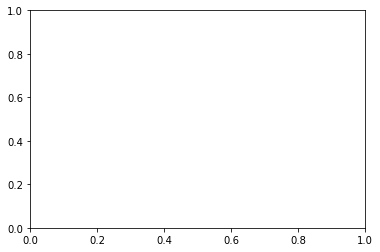

In [161]:
import sys
print(sys.getrecursionlimit())
sys.setrecursionlimit(3500)
import matplotlib.pyplot as plt
# Extract the relevant columns from the dataframe
x = joined_df_4['relevance']
y = joined_df_4['rating']

# Create the scatter plot
plt.scatter(x, y)

# Add labels and title to the plot
plt.xlabel('Tag relevance')
plt.ylabel('Rating')
plt.title('Scatter plot of tag relevance and rating')

# Show the plot
plt.show()

In [29]:
df = joined_df_4.select("movieId", "userId", "tagId", "imdbId", "tmdbId", "title", "genres", "rating", "relevance")
df.show()

+-------+------+-----+------+------+----------------+---------+------+---------+
|movieId|userId|tagId|imdbId|tmdbId|           title|   genres|rating|relevance|
+-------+------+-----+------+------+----------------+---------+------+---------+
|      1| 88055|  204|114709|   862|Toy Story (1995)|  Fantasy|   3.0|  0.96425|
|      1| 88055|  204|114709|   862|Toy Story (1995)|   Comedy|   3.0|  0.96425|
|      1| 88055|  204|114709|   862|Toy Story (1995)| Children|   3.0|  0.96425|
|      1| 88055|  204|114709|   862|Toy Story (1995)|Animation|   3.0|  0.96425|
|      1| 88055|  204|114709|   862|Toy Story (1995)|Adventure|   3.0|  0.96425|
|      1| 51492|  204|114709|   862|Toy Story (1995)|  Fantasy|   2.0|  0.96425|
|      1| 51492|  204|114709|   862|Toy Story (1995)|   Comedy|   2.0|  0.96425|
|      1| 51492|  204|114709|   862|Toy Story (1995)| Children|   2.0|  0.96425|
|      1| 51492|  204|114709|   862|Toy Story (1995)|Animation|   2.0|  0.96425|
|      1| 51492|  204|114709

In [46]:
joined_df.show()

+-------+--------------------+---------+------+------+----------+
|movieId|               title|   genres|userId|rating| timestamp|
+-------+--------------------+---------+------+------+----------+
|      2|      Jumanji (1995)|  Fantasy|     1|   3.5|1112486027|
|      2|      Jumanji (1995)| Children|     1|   3.5|1112486027|
|      2|      Jumanji (1995)|Adventure|     1|   3.5|1112486027|
|     29|City of Lost Chil...|   Sci-Fi|     1|   3.5|1112484676|
|     29|City of Lost Chil...|  Mystery|     1|   3.5|1112484676|
|     29|City of Lost Chil...|  Fantasy|     1|   3.5|1112484676|
|     29|City of Lost Chil...|    Drama|     1|   3.5|1112484676|
|     29|City of Lost Chil...|Adventure|     1|   3.5|1112484676|
|     32|Twelve Monkeys (a...| Thriller|     1|   3.5|1112484819|
|     32|Twelve Monkeys (a...|   Sci-Fi|     1|   3.5|1112484819|
|     32|Twelve Monkeys (a...|  Mystery|     1|   3.5|1112484819|
|     47|Seven (a.k.a. Se7...| Thriller|     1|   3.5|1112484727|
|     47|S

In [47]:
dataset = joined_df.groupBy("userId","title").agg(_avg("rating"))
dataset.show()

+------+--------------------+-----------+
|userId|               title|avg(rating)|
+------+--------------------+-----------+
|    11|         Jaws (1975)|        4.0|
|    11|      Gattaca (1997)|        5.0|
|    11|Appleseed (Appuru...|        5.0|
|    13|  Judge Dredd (1995)|        3.0|
|    14|Singin' in the Ra...|        3.5|
|    14|   Cinderella (1950)|        4.0|
|    18|Being John Malkov...|        4.0|
|    18|Lord of the Rings...|        3.0|
|    21|Shawshank Redempt...|        5.0|
|    22|Few Good Men, A (...|        5.0|
|    22|Rambo: First Bloo...|        5.0|
|    24|     Swingers (1996)|        5.0|
|    24|Beavis and Butt-H...|        4.0|
|    24|Godfather: Part I...|        4.0|
|    24|        Blade (1998)|        4.0|
|    24|  About a Boy (2002)|        4.0|
|    25|  Matrix, The (1999)|        3.5|
|    26|Dumb & Dumber (Du...|        2.0|
|    29|Léon: The Profess...|        4.0|
|    31|Lion King, The (1...|        3.0|
+------+--------------------+-----

In [ ]:
# USING MLIB

In [31]:
# Import the required functions

# Create ALS model
als = ALS(
         userCol="userId", 
         itemCol="movieId",
         ratingCol="rating", 
         nonnegative = True, 
         implicitPrefs = False,
         coldStartStrategy="drop"
)

In [33]:
# Import the requisite packages
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

In [34]:
# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [10, 50, 100, 150]) \
            .addGrid(als.regParam, [.01, .05, .1, .15]) \
            .build()

In [35]:
# Define evaluator as RMSE and print length of evaluator
evaluator = RegressionEvaluator(
           metricName="rmse", 
           labelCol="rating", 
           predictionCol="prediction") 
print ("Num models to be tested: ", len(param_grid))

Num models to be tested:  16


In [38]:
# Build cross validation using CrossValidator
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

In [37]:
print("**Best Model**")
# Print "Rank"
print("  Rank:", best_model._java_obj.parent().getRank())
# Print "MaxIter"
print("  MaxIter:", best_model._java_obj.parent().getMaxIter())
# Print "RegParam"
print("  RegParam:", best_model._java_obj.parent().getRegParam())

**Best Model**


NameError: name 'best_model' is not defined

In [39]:
# Fit cross validator to the 'train' dataset
model = cv.fit(train)
#Extract best model from the cv model above
best_model = model.bestModel
# View the predictions
test_predictions = best_model.transform(test)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

NameError: name 'train' is not defined